In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# read companies file with entries separated by tab
companies = pd.read_csv('companies.txt', encoding = "ISO-8859-1", sep='\t')
# read rounds2 csv
rounds2 = pd.read_csv('rounds2.csv', encoding = "ISO-8859-1")

In [3]:
# get number of unique companies in rounds2 dataset
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
print('Number of unique companies in rounds2:', rounds2['company_permalink'].nunique(dropna=True))

# get number of unique companies in companies dataset
companies['permalink'] = companies['permalink'].str.lower()
print('Number of unique companies in companies.txt:', companies['permalink'].nunique(dropna=True))

Number of unique companies in rounds2: 66370
Number of unique companies in companies.txt: 66368


In [4]:
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [5]:
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


In [6]:
# inner merge on permalink
master_frame = companies.join(rounds2.set_index(['company_permalink']), how='inner', on='permalink')

In [7]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114942 entries, 0 to 66367
Data columns (total 15 columns):
permalink                  114942 non-null object
name                       114941 non-null object
homepage_url               108810 non-null object
category_list              111535 non-null object
status                     114942 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94422 non-null object
funding_round_permalink    114942 non-null object
funding_round_type         114942 non-null object
funding_round_code         31139 non-null object
funded_at                  114942 non-null object
raised_amount_usd          94958 non-null float64
dtypes: float64(1), object(14)
memory usage: 14.0+ MB


In [8]:
# Data cleanup - drop irrelevant columns
master_frame = master_frame.drop(columns=['status', 'state_code', 
                                          'region', 'city', 'founded_at', 
                                          'funding_round_permalink', 'funding_round_code', 
                                          'funded_at', 'homepage_url'])
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114942 entries, 0 to 66367
Data columns (total 6 columns):
permalink             114942 non-null object
name                  114941 non-null object
category_list         111535 non-null object
country_code          106271 non-null object
funding_round_type    114942 non-null object
raised_amount_usd     94958 non-null float64
dtypes: float64(1), object(5)
memory usage: 6.1+ MB


In [9]:
# Data cleanup - find the percentage of missing values
def print_missing_values(df):
    print('Percentage of missing values\n{}'.format(((df.isnull().sum()/len(df.index)) * 100).round(2)))
    
print_missing_values(master_frame)

Percentage of missing values
permalink              0.00
name                   0.00
category_list          2.96
country_code           7.54
funding_round_type     0.00
raised_amount_usd     17.39
dtype: float64


In [10]:
# cleanup 'raised_amount_usd'  missing values by dropping them
master_frame.dropna(subset=['raised_amount_usd'], inplace=True)
# cleanup category_list and country code  missing values by imputing them to their mode values
master_frame['category_list'] = master_frame['category_list'].fillna(master_frame['category_list'].mode()[0])
master_frame['country_code'] = master_frame['country_code'].fillna(master_frame['country_code'].mode()[0])

print_missing_values(master_frame)

Percentage of missing values
permalink             0.0
name                  0.0
category_list         0.0
country_code          0.0
funding_round_type    0.0
raised_amount_usd     0.0
dtype: float64


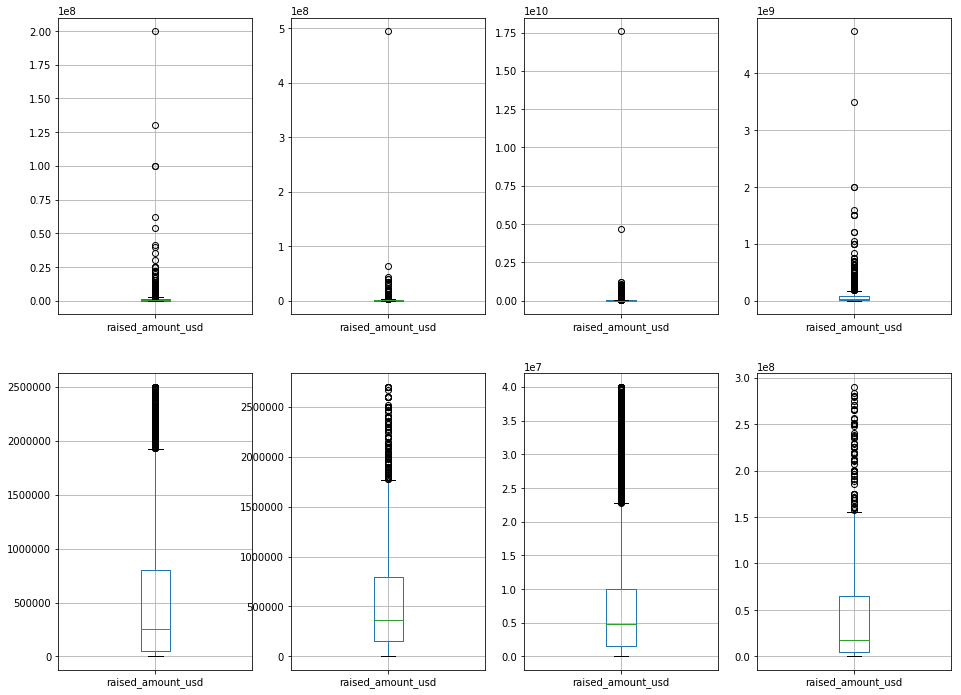

In [11]:
# Data cleanup - remove outliers
outlier_frame = master_frame.copy()

plt.figure(figsize=[16, 12])

fund_types = ['seed', 'angel', 'venture', 'private_equity']

# box plots
for i, fund_type in enumerate(fund_types):
    plt.subplot(2, 4, i+1)
    outlier_frame[outlier_frame['funding_round_type'] == fund_type].boxplot(['raised_amount_usd'])

def filter_out_percentile(series):
    filter_percentile = np.percentile(series, 95)
    return series <= filter_percentile

# remove outliers in each of the funding types
outlier_frame = outlier_frame[outlier_frame.groupby('funding_round_type')['raised_amount_usd'].transform(lambda x: filter_out_percentile(x))]

# box plots    
for i, fund_type in enumerate(fund_types):
    plt.subplot(2, 4, i+5)
    outlier_frame[outlier_frame['funding_round_type'] == fund_type].boxplot(['raised_amount_usd'])

plt.show()

master_frame = outlier_frame.copy()

In [12]:
# get average funding for each funding type
funding_type_averages = {}
fund_types = ['venture', 'angel', 'seed', 'private_equity']

mean_df = master_frame.groupby('funding_round_type')['raised_amount_usd'].mean().round(2)
for fund_type in fund_types:
    funding_type_averages[fund_type] = mean_df[fund_type]

print(f'Average funding amount:{funding_type_averages}')

Average funding amount:{'venture': 7609093.03, 'angel': 564802.81, 'seed': 520533.95, 'private_equity': 43614888.52}


In [13]:
selected_funding_type = None
for fund_type in fund_types:
    if (funding_type_averages[fund_type] >= 5000000) and (funding_type_averages[fund_type] <= 15000000):
        selected_funding_type = fund_type
        break

fund_type_master_frame = master_frame[master_frame['funding_round_type']==selected_funding_type]
        
top9 = fund_type_master_frame.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).head(9)

In [14]:
# top 9 countries in terms of veture investment across sectors 
top9

country_code
USA    2.825398e+11
GBR    1.417446e+10
CHN    1.371721e+10
CAN    8.057730e+09
IND    7.011359e+09
ISR    6.074515e+09
FRA    5.599263e+09
DEU    4.228129e+09
CHE    2.053605e+09
Name: raised_amount_usd, dtype: float64

In [15]:
# programatically figure out the top 3 English speaking countries
list_of_english_speaking_country_codes = set()

import requests
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language').text
from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url, 'lxml')
tables = soup.findAll('table', {'class':'wikitable sortable'})

# table 1
for row in tables[0].find('tbody').findAll('tr'):
    tds = row.findAll('td')
    if tds:
        item = tds[2]
        code = str(item).replace('<td>','').replace('\n</td>', '')
        if code:
            list_of_english_speaking_country_codes.add(code)

# table 2
for row in tables[1].find('tbody').findAll('tr'):
    tds = row.findAll('td')
    if tds:
        item = tds[2]
        code = str(item).replace('<td>','').replace('\n</td>', '')
        if code:
            list_of_english_speaking_country_codes.add(code)
        
print(list_of_english_speaking_country_codes)

top3_english_speaking_countries = []
for top in top9.index:
    if top in list_of_english_speaking_country_codes:
        top3_english_speaking_countries.append(top)
top3_english_speaking_countries = top3_english_speaking_countries[0:3]
print(f'Top 3 English speaking countries in the list:\n{top3_english_speaking_countries}')

{'RWA', 'BHS', 'FJI', 'GUY', 'VCT', 'SGP', 'MHL', 'CAN', 'KIR', 'TON', 'ATG', 'NGA', 'PLW', 'ZWE', 'PAK', 'MUS', 'KEN', 'GBR', 'PNG', 'TZA', 'LBR', 'GHA', 'FSM', 'NIU', 'KNA', 'ZAF', 'SSD', 'LSO', 'SDN', 'BDI', 'JAM', 'ZMB', 'TTO', 'TUV', 'VUT', 'MLT', 'BLZ', 'LCA', 'SLB', 'DMA', 'USA', 'AUS', 'WSM', 'UGA', 'GMB', 'GRD', 'NZL', 'PHL', 'CMR', 'MWI', 'SYC', 'COK', 'IND', 'IRL', 'SWZ', 'SLE', 'BRB', 'BWA', 'NAM'}
Top 3 English speaking countries in the list:
['USA', 'GBR', 'CAN']


In [16]:
# read mappings file
map_df = pd.read_csv('mapping.csv')

# drop NaN row and Blanks column
map_df = map_df.drop(columns=['Blanks'])
map_df = map_df.dropna()
map_df.head()

,category_list,Automotive & Sports,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
1,3D,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,1
5,Active Lifestyle,0,0,0,1,0,0,0,0


In [17]:
# update primary sector in master dataframe
master_frame['primary_sector'] = master_frame['category_list'].str.split('|').str[0]
master_frame.head()

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,primary_sector
0,/organization/-fame,#fame,Media,IND,venture,10000000.0,Media
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,seed,700000.0,Application Platforms
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,USA,venture,3406878.0,Apps
3,/organization/0-6-com,0-6.com,Curated Web,CHN,venture,2000000.0,Curated Web
5,/organization/01games-technology,01Games Technology,Games,HKG,undisclosed,41250.0,Games


In [18]:
# create a copy of mapping dataset
mapped_df = map_df.filter(['category_list'], axis=1)

# function to get column name with value one for each row in mapping dataframe
def get_main_sector(row):
    return(row.index[row.apply(lambda x: x==1)][0])
    
# prepare a main_sector column which contains the mapping of primary sector
mapped_df['main_sector'] = map_df.apply(lambda row:get_main_sector(row), axis=1)
mapped_df.head()

,category_list,main_sector
1,3D,Manufacturing
2,3D Printing,Manufacturing
3,3D Technology,Manufacturing
4,Accounting,"Social, Finance, Analytics, Advertising"
5,Active Lifestyle,Health


In [19]:
# merge master df with a mapping to main sector
merged_df = master_frame.join(mapped_df.set_index('category_list'), on='primary_sector', how='inner')

master_frame = merged_df.copy()
master_frame.head()


,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,Media,IND,venture,10000000.0,Media,Entertainment
547,/organization/90min,90min,Media|News|Publishing|Soccer|Sports,GBR,venture,15000000.0,Media,Entertainment
547,/organization/90min,90min,Media|News|Publishing|Soccer|Sports,GBR,venture,5800000.0,Media,Entertainment
547,/organization/90min,90min,Media|News|Publishing|Soccer|Sports,GBR,venture,18000000.0,Media,Entertainment
608,/organization/a-dance-for-me,A Dance for Me,Media|News|Photo Sharing|Video,USA,equity_crowdfunding,1090000.0,Media,Entertainment


In [20]:
# filter out top funding type and range of funding from master_frame
fund_type_range_master_frame = master_frame[(master_frame['funding_round_type'] == selected_funding_type) \
                                            & (master_frame['raised_amount_usd'] <= 15000000) \
                                            & (master_frame['raised_amount_usd'] >= 5000000)]

D1 = fund_type_range_master_frame[(fund_type_range_master_frame['country_code'] == top3_english_speaking_countries[0])]
D2 = fund_type_range_master_frame[(fund_type_range_master_frame['country_code'] == top3_english_speaking_countries[1])]
D3 = fund_type_range_master_frame[(fund_type_range_master_frame['country_code'] == top3_english_speaking_countries[2])]

In [21]:
investment_count_D1 = D1['raised_amount_usd'].count()
print(f'Number of investments in {top3_english_speaking_countries[0]}: {investment_count_D1}')
investment_count_D2 = D2['raised_amount_usd'].count()
print(f'Number of investments in {top3_english_speaking_countries[1]}: {investment_count_D2}')
investment_count_D3 = D3['raised_amount_usd'].count()
print(f'Number of investments in {top3_english_speaking_countries[2]}: {investment_count_D3}')

Number of investments in USA: 11912
Number of investments in GBR: 584
Number of investments in CAN: 398


In [22]:
investment_amount_D1 = D1['raised_amount_usd'].sum()
print(f'Amount of investments in {top3_english_speaking_countries[0]}: {investment_amount_D1}')
investment_amount_D2 = D2['raised_amount_usd'].sum()
print(f'Amount of investments in {top3_english_speaking_countries[1]}: {investment_amount_D2}')
investment_amount_D3 = D3['raised_amount_usd'].sum()
print(f'Amount of investments in {top3_english_speaking_countries[2]}: {investment_amount_D3}')

Amount of investments in USA: 106354355599.0
Amount of investments in GBR: 5086469206.0
Amount of investments in CAN: 3422009576.0


In [23]:
for D in [D1, D2, D3]:
    # set counts for each main sector
    group_by_df = D.groupby('main_sector').count()['raised_amount_usd']
    D['investment_count'] = D['main_sector'].apply(lambda x: group_by_df[x])
    
    # set sum for each main sector
    group_by_df = D.groupby('main_sector').sum()['raised_amount_usd']
    D['investment_sum'] = D['main_sector'].apply(lambda x: group_by_df[x]) 


/home/shakeeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/shakeeb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
# top 3 sectors and their counts
top_sectors_count_D1 = D1.groupby(['main_sector', 'investment_count'])['raised_amount_usd'].count().sort_values(ascending=False)
top_3_sectors_D1 = top_sectors_count_D1[0:3]
top_3_sectors_D1

main_sector                              investment_count
Others                                   3063                3063
Cleantech / Semiconductors               2548                2548
Social, Finance, Analytics, Advertising  2008                2008
Name: raised_amount_usd, dtype: int64

In [25]:
top_sectors_count_D2 = D2.groupby(['main_sector', 'investment_count'])['raised_amount_usd'].count().sort_values(ascending=False)
top_3_sectors_D2 = top_sectors_count_D2[0:3]
top_3_sectors_D2

main_sector                              investment_count
Others                                   143                 143
Cleantech / Semiconductors               134                 134
Social, Finance, Analytics, Advertising  98                   98
Name: raised_amount_usd, dtype: int64

In [26]:
top_sectors_count_D3 = D3.groupby(['main_sector', 'investment_count'])['raised_amount_usd'].count().sort_values(ascending=False)
top_3_sectors_D3 = top_sectors_count_D3[0:3]
top_3_sectors_D3

main_sector                              investment_count
Cleantech / Semiconductors               116                 116
Others                                   109                 109
Social, Finance, Analytics, Advertising  52                   52
Name: raised_amount_usd, dtype: int64

In [27]:
D1[D1['main_sector'] == top_3_sectors_D1.index[0][0]].sort_values('raised_amount_usd', ascending=False).head(2)

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,primary_sector,main_sector,investment_count,investment_sum
118,/organization/1stdibs,1stdibs,E-Commerce,USA,venture,15000000.0,E-Commerce,Others,3063,2.722281e+10
31735,/organization/le-tote,LE TOTE,E-Commerce|Fashion,USA,venture,15000000.0,E-Commerce,Others,3063,2.722281e+10


In [28]:
D2[D2['main_sector'] == top_3_sectors_D2.index[0][0]].sort_values('raised_amount_usd', ascending=False).head(2)

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,primary_sector,main_sector,investment_count,investment_sum
59320,/organization/tribold,Tribold,Software,GBR,venture,15000000.0,Software,Others,143,1.249124e+09
50566,/organization/sensage,SenSage,Security,GBR,venture,15000000.0,Security,Others,143,1.249124e+09


In [29]:
D3[D3['main_sector'] == top_3_sectors_D3.index[0][0]].sort_values('raised_amount_usd', ascending=False).head(2)

,permalink,name,category_list,country_code,funding_round_type,raised_amount_usd,primary_sector,main_sector,investment_count,investment_sum
15486,/organization/diablo-technologies,Diablo Technologies,Semiconductors,CAN,venture,15000000.0,Semiconductors,Cleantech / Semiconductors,116,1.063607e+09
66344,/organization/zymeworks,Zymeworks,Biotechnology,CAN,venture,15000000.0,Biotechnology,Cleantech / Semiconductors,116,1.063607e+09


In [30]:
# plotting

# total investment across
total_investment = master_frame['raised_amount_usd'].sum()

# fraction of total investments in venture type
sum_df = master_frame.groupby('funding_round_type').sum()
venture_p = (sum_df.loc['venture']['raised_amount_usd'] / total_investment) * 100
seed_p = (sum_df.loc['seed']['raised_amount_usd'] / total_investment) * 100
pe_p = (sum_df.loc['private_equity']['raised_amount_usd'] / total_investment) * 100

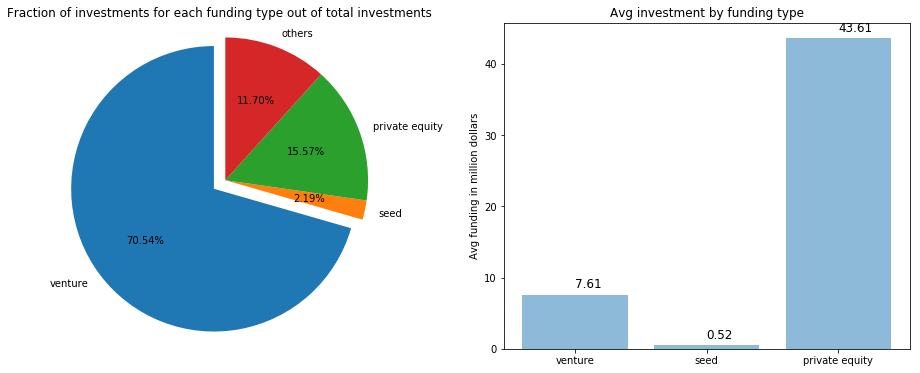

In [31]:
plt.figure(figsize=(16,6))

# subplot 1
plt.subplot(1, 2, 1)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'venture', 'seed', 'private equity', 'others'
sizes = [venture_p, seed_p, pe_p, 100-(venture_p + seed_p + pe_p)]
explode = (0.1, 0, 0, 0)  # only "explode" the venture slice

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Fraction of investments for each funding type out of total investments')

# subplot 2
plt.subplot(1, 2, 2)

# Bar chart denoting the average investments in venture, seed and private_equity
labels = ('venture', 'seed', 'private equity')
sizes = [funding_type_averages['venture']/1000000,
         funding_type_averages['seed']/1000000,
         funding_type_averages['private_equity']/1000000]
plt.bar(labels, sizes, align='center', alpha=0.5)
# Put numerical values as text on bars
for i, x in enumerate(sizes):
    plt.text(i, x+1, s=f"{x:.2f}" , fontdict=dict(fontsize=12))

plt.ylabel('Avg funding in million dollars')
plt.title('Avg investment by funding type')

plt.show()

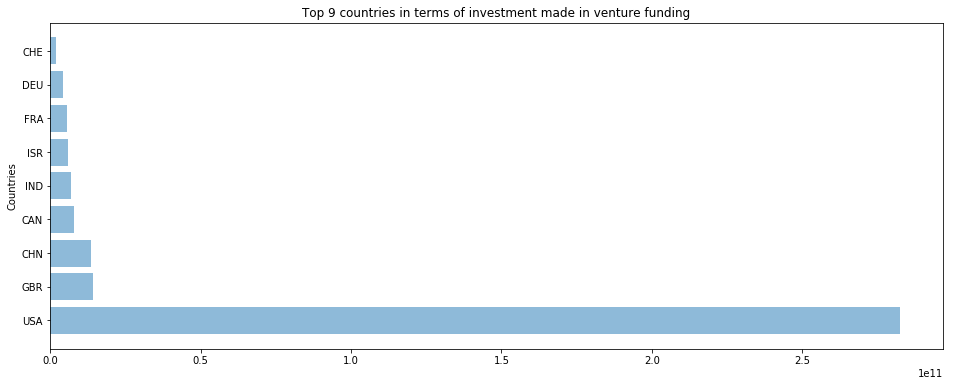

In [32]:
plt.figure(figsize=(16,6))
plt.subplot(1, 1, 1)

labels = top9.index
plt.barh(labels, top9, align='center', alpha=0.5)

plt.ylabel('Countries')
plt.title('Top 9 countries in terms of investment made in venture funding')

plt.show()

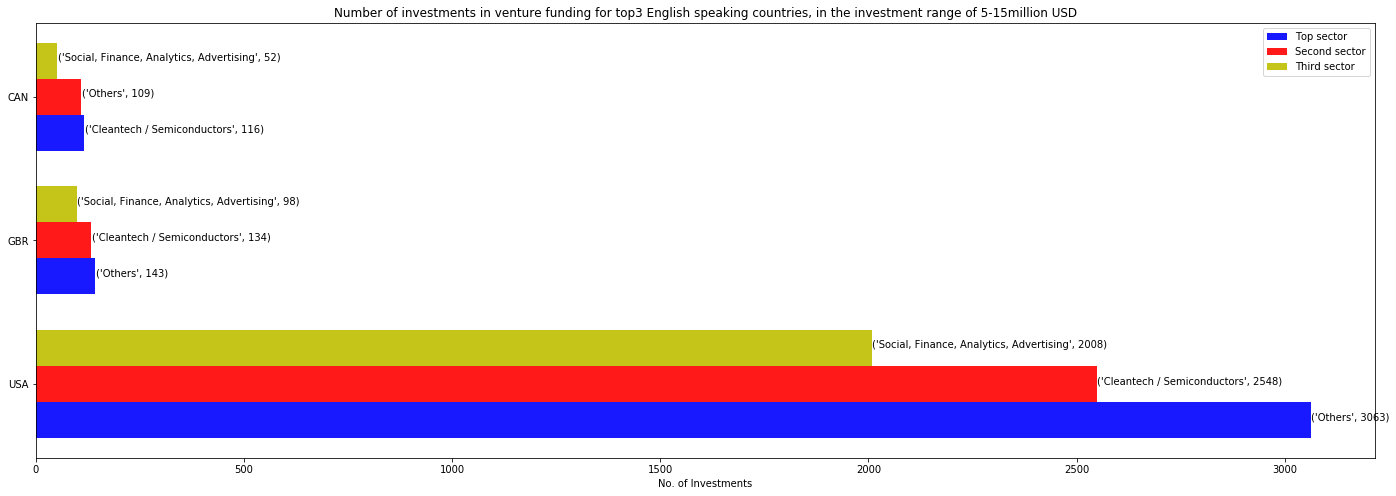

In [33]:
plt.figure(figsize=(24,8))
plt.subplot(1, 1, 1)
labels = (1, 2, 3)

ind = np.arange(3)   # the x locations for the groups
width = 0.25         # the width of the bars

colors = ['b', 'r', 'y']
# in each loop, each sector is plotted for all the 3 countries
for n in range(3):
    sizes = [top_3_sectors_D1[n], top_3_sectors_D2[n], top_3_sectors_D3[n]]
    labels = [top_3_sectors_D1.index[n], top_3_sectors_D2.index[n], top_3_sectors_D3.index[n]]
    plt.barh(ind+(n*width), sizes, height=width, color=colors[n], alpha=0.9)
    for i, x in enumerate(labels):
        plt.text(i+sizes[i], i+(n*width), s=x , fontdict=dict(fontsize=10))

plt.yticks(ind+width, labels=top3_english_speaking_countries)
plt.legend(['Top sector', 'Second sector', 'Third sector'])

plt.xlabel('No. of Investments')
plt.title('Number of investments in venture funding for top3 English speaking countries, in the investment range of 5-15million USD')
plt.autoscale()

plt.show()